In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
n = 1000
noise = .2
test_size = .2
val_size = .3

seed = 10
def set_seed(seed = 8):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(seed)

## Data

In [3]:
X, y = make_moons(n_samples=n, shuffle=True, noise=noise, random_state=seed)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          test_size=test_size,
                                                          random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=val_size,
                                                  random_state=seed)

Text(0.5, 1.0, 'toy data')

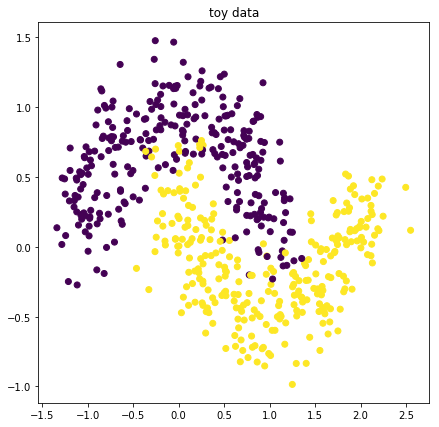

In [4]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, marker = 'o')
ax.set_title('toy data')

## Experiments

In [5]:
# define model
class BasicNet(nn.Module):
    
    inputDim = 2
    outputDim = 1
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(BasicNet.inputDim, BasicNet.outputDim) # initializes at random
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [6]:
# define model
class FCNet(nn.Module):
    
    inputDim = 2
    outputDim = 1
    
    def __init__(self, h):
        """ h: number of units in hidden layer """
        super().__init__()
        
        self.fc1 = nn.Linear(BasicNet.inputDim, h) # initializes at random
        self.fc2 = nn.Linear(h, BasicNet.outputDim) # initializes at random

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [7]:
# instanciate model and setup
# model = BasicNet()
model = FCNet(100)

lossfn = nn.BCELoss() # BinaryCrossEntropy
# optimizer = optim.SGD(model.parameters(), lr=0.1) # using a better optimizer DOES make a difference
optimizer = optim.RMSprop(model.parameters(),
                          lr=0.01,
                          alpha=0.99,
                          eps=1e-08,
                          weight_decay=0,
                          momentum=0.9,
                          centered=False)
# optimizer = optim.Adam(model.parameters(),
#                        lr=0.01,
#                        betas=(0.9, 0.999),
#                        eps=1e-08,
#                        weight_decay=0,
#                        amsgrad=False)
for p in model.parameters():
    print(p.size())

torch.Size([100, 2])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


[1] error: 0.657761812210083
[11] error: 0.35133370757102966
[21] error: 0.340938001871109
[31] error: 0.18498942255973816
[41] error: 0.10747390240430832
[51] error: 0.09758636355400085
[61] error: 0.09218745678663254
[71] error: 0.08866553008556366
[81] error: 0.08722278475761414
[91] error: 0.08616599440574646
[last] error: 0.08542744815349579
Finished Training


Text(0.5, 1.0, 'train loss')

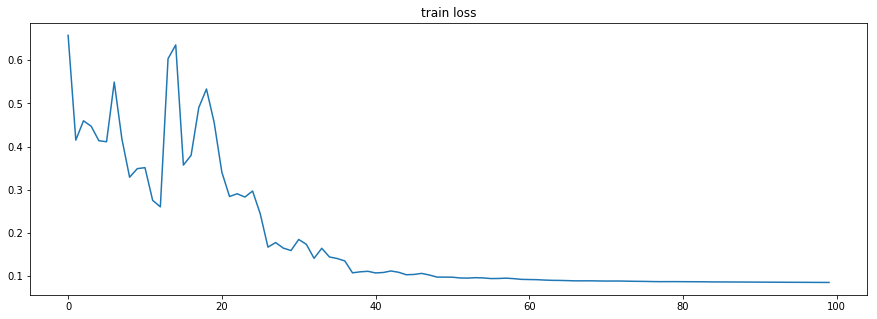

In [8]:
# train model
_X = torch.tensor(X_train, dtype=torch.float)
_y = torch.tensor(y_train, dtype=torch.float).view(-1, 1) # reshape with one column
_aloss = []

for epoch in range(100):  # loop over the dataset multiple times
  
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # no minibatch here: take whole dataset
    fX = model(_X)
    loss = lossfn(fX, _y); _aloss.append(loss)
    loss.backward()
    optimizer.step()
        
    # print statistics
    if epoch % 10 == 0:
        print('[{}] error: {}'.format(epoch + 1, loss))

fX = model(_X)
loss = lossfn(fX, _y)
print('[last] error: {}'.format(loss))

print('Finished Training')

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(_aloss)
ax.set_title('train loss')

Text(0.5, 1.0, 'prediction')

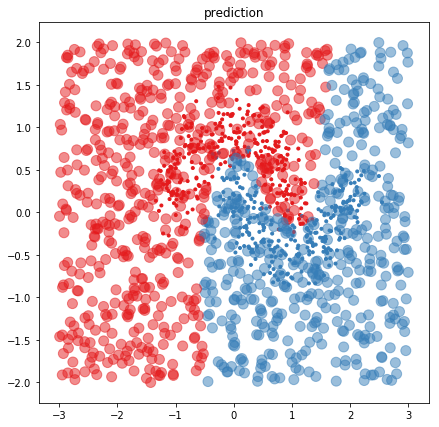

In [13]:
_X = torch.rand((1000,2), dtype=torch.float) * torch.tensor((6.,4.)) - torch.tensor((3.,2.))
_yhat = [int(x) for x in model.predict(_X).detach().numpy().flatten()]

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train[:,0], X_train[:,1], c=cm.Set1(y_train), marker = '.')
ax.scatter(_X[:,0], _X[:,1], c=cm.Set1(_yhat), s=100, marker = 'o', alpha=.5)
ax.set_title('prediction')